In [10]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Clinical data preparation (Pre-Training)

In [3]:
#read the data
pre_training_data_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/Pre-training/Colorectal-Liver-Metastases-Clinical-data-April-2023.xlsx"
pre_training_data = pd.read_excel(pre_training_data_path)


c:\Users\P095550\OneDrive - Amsterdam UMC\Documenten\GitHub\CRLM-morph-features\.venv\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [4]:
relevant_data = pre_training_data[['Patient-ID', 'overall_survival_months']]
relevant_data = relevant_data.drop(index=72) #this patient was scanned on its stomach

relevant_data.isna().sum()


Patient-ID                 0
overall_survival_months    0
dtype: int64

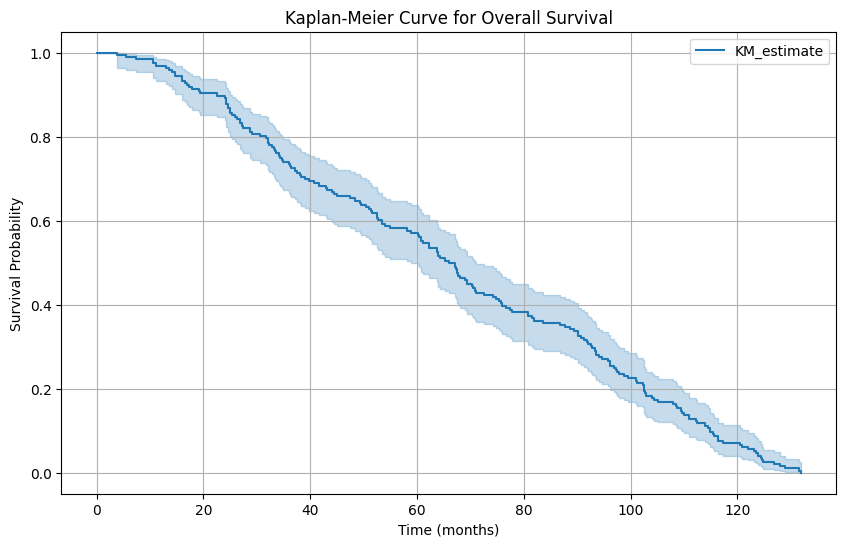

In [5]:
# Initialize the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Fit the data
kmf.fit(durations=relevant_data['overall_survival_months'], event_observed=None)

# Plot the Kaplan-Meier survival curve
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Kaplan-Meier Curve for Overall Survival')
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

In [ ]:
# Read the metadata CSV file
metadata_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/Pre-training/dataset/metadata.csv"

# Replace with the actual path to your metadata file
metadata = pd.read_csv(metadata_path)

print(metadata['Number of Images'])

#max number of images is 126

# Clinical data preparation (Training, CAIRO5)

In [2]:
#Read in the data
data_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/dataset_CAESAR_dec23_MASTER.xlsx"
all_data = pd.read_excel(data_path)

pat_resp_data_path = "C:/Users/P095550/OneDrive - Amsterdam UMC/Documenten/GitHub/CRLM-morph-features/CAIRO5_path_responseTRG__dec2023.xlsx"
pat_resp_data = pd.read_excel(pat_resp_data_path)



In [11]:
relavant_data = all_data[["SubjectKey", "KRAS", "BRAF", "NRAS", "treatment", "PFSm", "OSm"]] #still add path. response 
relavant_data.head()

,SubjectKey,KRAS,BRAF,NRAS,treatment,PFSm,OSm
0,1,0,1,0,FOLFOX-B,11.400411,22.406571
1,2,0,0,0,FOLFOX-P,7.687885,48.394251
2,3,1,0,0,FOLFOX-B,8.147844,31.671458
3,4,0,0,0,FOLFOX-P,21.880903,37.355236
4,5,0,0,0,FOLFIRI-B,1.609856,4.435318


In [12]:
#select subjects with scans

scans_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/Training/paired_tumor_scans"
subjects = []

for scan in os.listdir(scans_path):
    subject = scan.split("_")[0]
    subject_int = int(subject[-3:])
    subjects.append(subject_int)

training_data = relavant_data[relavant_data["SubjectKey"].isin(subjects)]

In [13]:
# 2 missing subjects: 73, 406
missing_subjects = set(subjects) - set(training_data["SubjectKey"])
print(missing_subjects)


set()


Delete scans of patient 104 (and 406 for tumor segmentations)

## Create input and labels

In [14]:
#merge the path. response

# Merge df2's "Response" column into df1 based on "SubjectKey"
training_data = pd.merge(training_data, pat_resp_data[["SubjectKey", "TRG_cat"]], on="SubjectKey", how="left")


In [62]:
training_data

,SubjectKey,KRAS,BRAF,NRAS,treatment,PFSm,OSm,TRG_cat
0,1,0,1,0,FOLFOX-B,11.400411,22.406571,NaN
1,4,0,0,0,FOLFOX-P,21.880903,37.355236,NaN
2,7,1,0,0,FOLFOXIRI-B,84.829569,84.829569,Major histological response
3,10,0,0,0,FOLFOX-B,6.275154,44.616016,No histological response
4,12,0,0,0,FOLFOX-P,7.622177,51.285421,NaN
...,...,...,...,...,...,...,...,...
283,570,0,0,0,FOLFOX-B,12.845996,22.767967,NaN
284,575,0,0,0,FOLFOX-P,9.560575,22.143737,NaN
285,580,0,0,0,FOLFOX-P,11.203285,19.088296,Partial histological response
286,583,0,0,0,FOLFOX-P,9.462012,17.741273,No histological response


In [15]:
# create input csv

training_input = training_data[["SubjectKey", "KRAS", "BRAF", "NRAS", "treatment", "TRG_cat"]]
training_labels = training_data[["SubjectKey", "PFSm", "OSm", "TRG_cat"]]


# One-hot encode treatment into two categories: ending with 'P' or 'B'
training_input['treatment_P'] = training_input['treatment'].str.endswith('P').astype(int)
training_input['treatment_B'] = training_input['treatment'].str.endswith('B').astype(int)

training_input.drop(columns=["SubjectKey", "treatment", "TRG_cat"], inplace= True)

#-----------------------------
# LABELS
#-------------------------------

#one-hot encode path. response into three categories: no resp, partial response, major response

# One-hot encode the TRG_cat column into three categories
training_labels['no_resp'] = (training_labels['TRG_cat'] == 'No histological response').astype(int)
training_labels['partial_resp'] = (training_labels['TRG_cat'] == 'Partial histological response').astype(int)
training_labels['major_resp'] = (training_labels['TRG_cat'] == 'Major histological response').astype(int)

# Convert rows where no_resp, partial_resp, and major_resp are all 0 to -1
training_labels.loc[
    (training_labels['no_resp'] == 0) & 
    (training_labels['partial_resp'] == 0) & 
    (training_labels['major_resp'] == 0), 
    ['no_resp', 'partial_resp', 'major_resp']
] = -1

half_year_pfs, one_year_pfs, two_year_pfs = 6, 12, 24  
one_year_os, three_year_os, five_year_os = 12, 36, 60  

# Create one-hot encoded columns for progression-free survival thresholds
training_labels['6m_PFS'] = (training_labels['PFSm'] >= half_year_pfs).astype(int)
training_labels['1y_PFS'] = (training_labels['PFSm'] >= one_year_pfs).astype(int)
training_labels['2y_PFS'] = (training_labels['PFSm'] >= two_year_pfs).astype(int)

# Create one-hot encoded columns for overall survival thresholds
training_labels['1y_OS'] = (training_labels['OSm'] >= one_year_os).astype(int)
training_labels['3y_OS'] = (training_labels['OSm'] >= three_year_os).astype(int)
training_labels['5y_OS'] = (training_labels['OSm'] >= five_year_os).astype(int)

training_labels.drop(columns=["SubjectKey", "PFSm", "OSm", "TRG_cat"], inplace= True)




C:\Users\P095550\AppData\Local\Temp\ipykernel_16844\1670222137.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_input['treatment_P'] = training_input['treatment'].str.endswith('P').astype(int)
C:\Users\P095550\AppData\Local\Temp\ipykernel_16844\1670222137.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_labels['no_resp'] = (training_labels['TRG_cat'] == 'No histological response').astype(int)
C:\Users\P095550\AppData\Local\Temp\ipykernel_16844\1670222137.py:21: SettingWithCopyWarnin

In [16]:
# Save the training input and labels to CSV files
training_input.to_csv('training_input.csv', index=False)
training_labels.to_csv('training_labels.csv', index=False)

In [49]:
training_labels

,TRG_no_resp,TRG_partial_resp,TRG_major_resp,6m_PFS,1y_PFS,2y_PFS,1y_OS,3y_OS,5y_OS
0,0,0,0,1,0,0,1,0,0
1,0,0,0,1,1,0,1,1,0
2,0,0,1,1,1,1,1,1,1
3,1,0,0,1,0,0,1,1,0
4,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...
283,0,0,0,1,1,0,1,0,0
284,0,0,0,1,0,0,1,0,0
285,0,1,0,1,0,0,1,0,0
286,1,0,0,1,0,0,1,0,0


In [12]:
# Count the number of 1's in each column
ones_count = training_input.iloc[:, 3:].sum()
print(ones_count)

NRAS                      14
treatment_FOLFIRI-B        9
treatment_FOLFIRI-P        6
treatment_FOLFOX-B       132
treatment_FOLFOX-P        55
treatment_FOLFOXIRI-B     86
dtype: int64


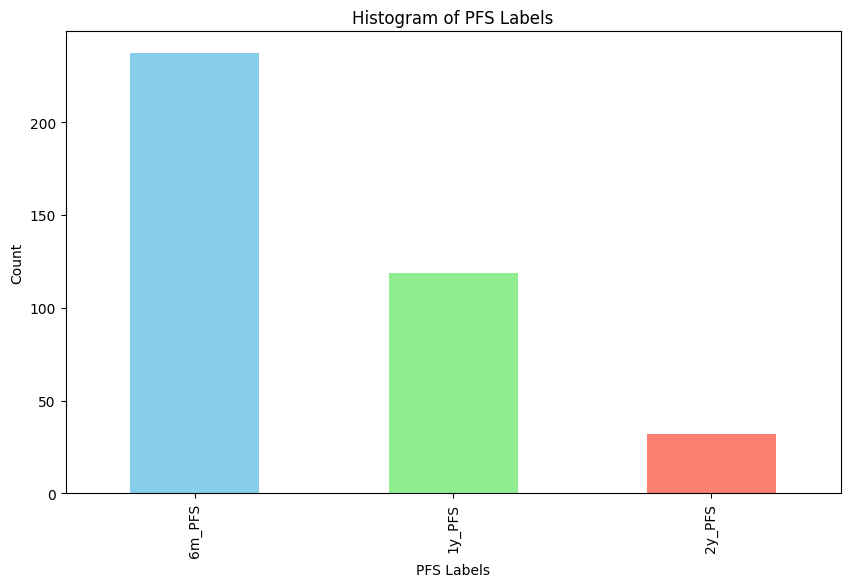

In [13]:
# Create a histogram for the three PFS labels
plt.figure(figsize=(10, 6))
training_labels[['6m_PFS', '1y_PFS', '2y_PFS']].sum().plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])

# Add labels and title
plt.xlabel('PFS Labels')
plt.ylabel('Count')
plt.title('Histogram of PFS Labels')

# Display the plot
plt.show()

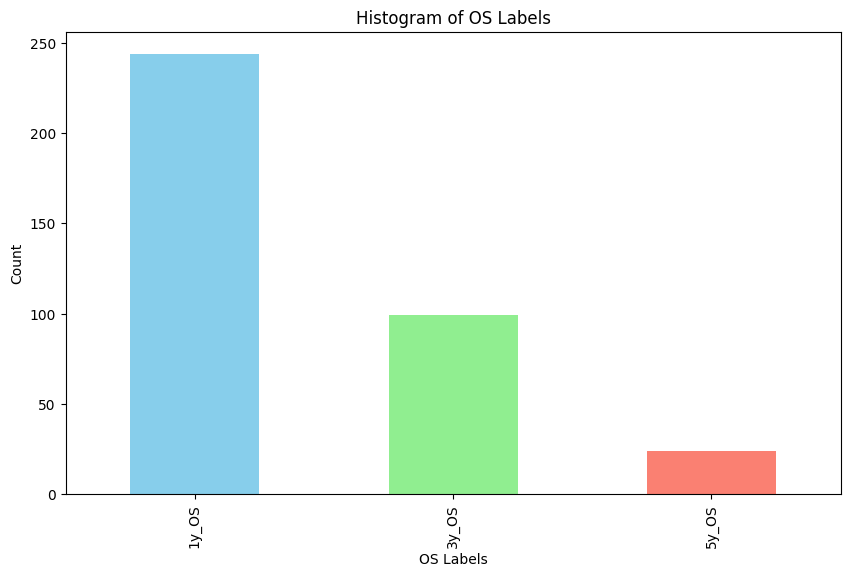

In [14]:
# Create a histogram for the three OS labels
plt.figure(figsize=(10, 6))
training_labels[['1y_OS', '3y_OS', '5y_OS']].sum().plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])

# Add labels and title
plt.xlabel('OS Labels')
plt.ylabel('Count')
plt.title('Histogram of OS Labels')

# Display the plot
plt.show()

In [15]:
# Calculate the percentage distribution of the OS labels
os_label_distribution = (training_labels[['1y_OS', '3y_OS', '5y_OS']].sum() / len(training_labels)) * 100

# Display the distribution
print(os_label_distribution)

1y_OS    84.722222
3y_OS    34.375000
5y_OS     8.333333
dtype: float64


In [16]:
# Calculate the percentage distribution of the PFS labels
pfs_label_distribution = (training_labels[['6m_PFS', '1y_PFS', '2y_PFS']].sum() / len(training_labels)) * 100

# Display the distribution
print(pfs_label_distribution)

6m_PFS    82.291667
1y_PFS    41.319444
2y_PFS    11.111111
dtype: float64


## Plots & Exploration

### Mutation status

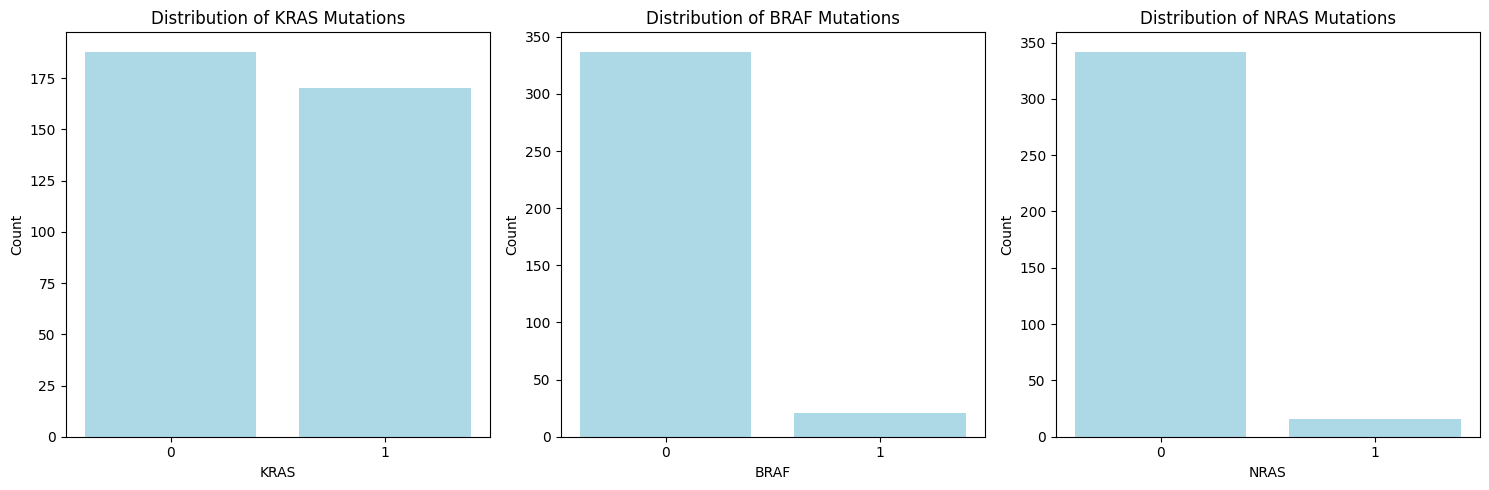

In [44]:
# Define the list of mutation columns to plot
mutation_columns = ["KRAS", "BRAF", "NRAS"]

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=len(mutation_columns), figsize=(15, 5))

# Create bar plots for each mutation type
for ax, mutation in zip(axes, mutation_columns):
    mutation_counts = data[mutation].value_counts()

    # Create a bar plot
    ax.bar(mutation_counts.index, mutation_counts.values, color='lightblue')

    # Add labels and title
    ax.set_xlabel(mutation)
    ax.set_ylabel('Count')
    ax.set_title(f'Distribution of {mutation} Mutations')

    # Fix the x-axis to display only 0 and 1
    ax.set_xticks([0, 1])

# Adjust layout
plt.tight_layout()

# Display the combined figure
plt.show()


### Treatment

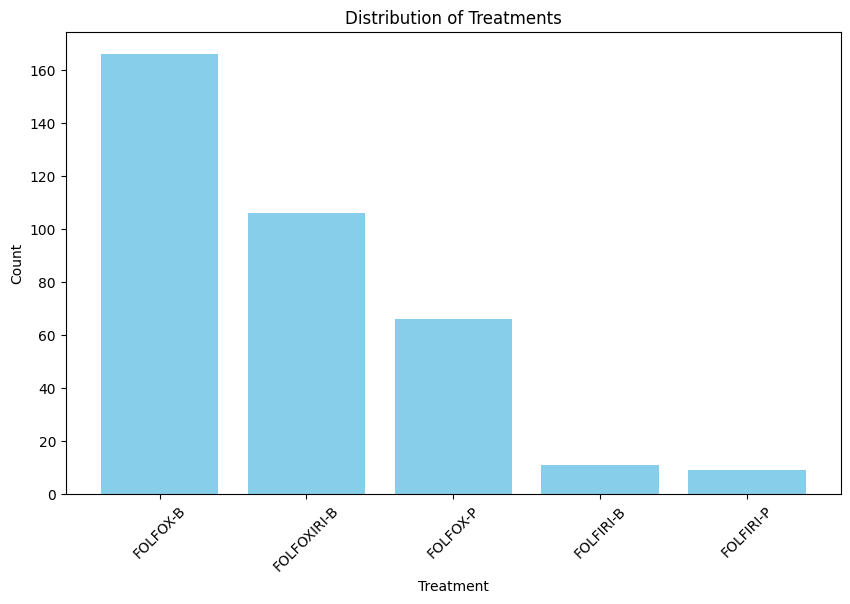

In [47]:
# Count the occurrences of each treatment type
treatment_counts = data["treatment"].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(treatment_counts.index, treatment_counts.values, color='skyblue')

# Add labels and title
plt.xlabel('Treatment')
plt.ylabel('Count')
plt.title('Distribution of Treatments')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()


### Overall survival

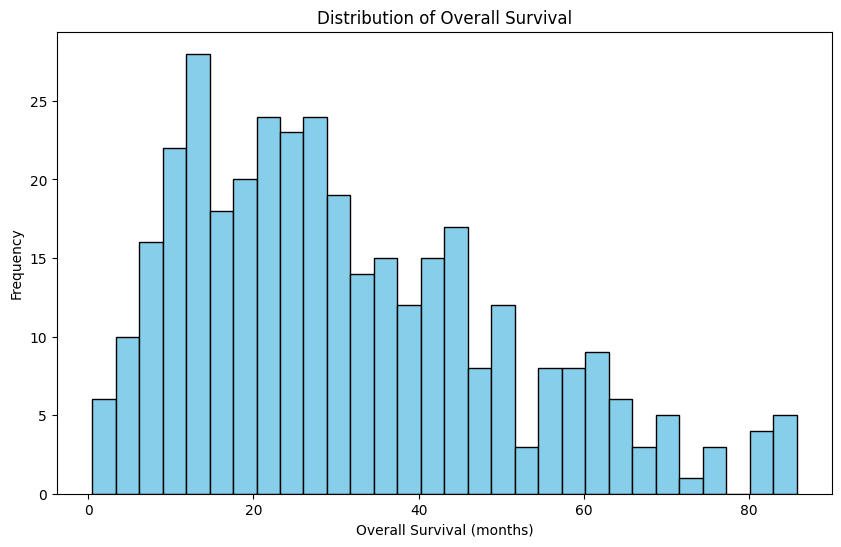

In [ ]:
# Initialize the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Fit the data
kmf.fit(durations=relavant_data['OSm'], event_observed=None)

# Plot the Kaplan-Meier survival curve
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Kaplan-Meier Curve for Overall Survival')
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

### Progression Free Survival

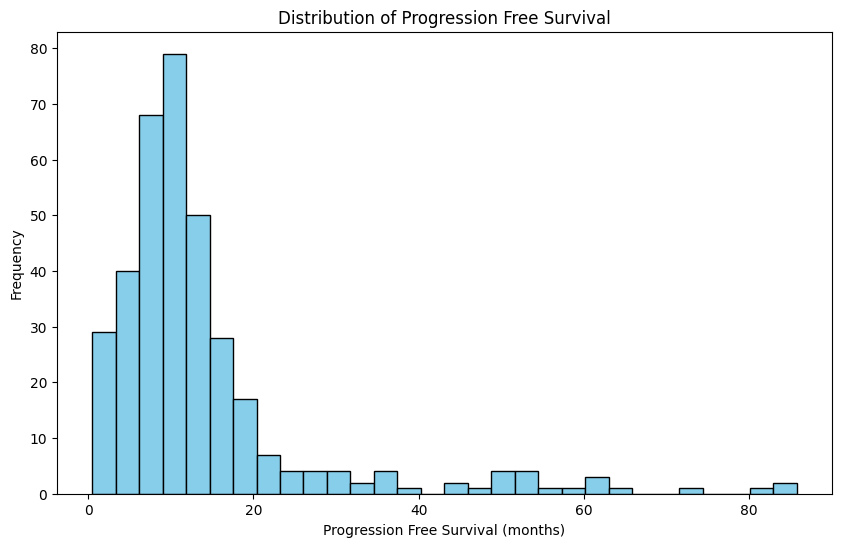

In [52]:
# Create a histogram plot for the distribution of progression free survival (PFSm)

plt.figure(figsize=(10, 6))
plt.hist(data['PFSm'], bins=30, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Progression Free Survival (months)')
plt.ylabel('Frequency')
plt.title('Distribution of Progression Free Survival')

# Display the plot
plt.show()

### Pathological response

In [ ]:
#add path. response

## Check for missing values

In [58]:
# Check for columns with NaN values
nan_columns = data.columns[data.isnull().any()]

# Print the columns with NaN values
print("Columns with NaN values:")
print(nan_columns)

Columns with NaN values:
Index([], dtype='object')


## Determining outcome variable

In [54]:
# Filter the data for patients with overall survival longer than 24 months
long_survival_patients = data[data['OSm'] > 24]

# Count the number of such patients
num_long_survival_patients = len(long_survival_patients)

print(f"Number of patients with overall survival longer than 24 months: {num_long_survival_patients}")
print(f"Total number of patients: {len(data)}")

Number of patients with overall survival longer than 24 months: 207
Total number of patients: 358


In [ ]:
# Filter the data for patients with progression free survival longer than 12 months
long_pfs_patients = data[data['PFSm'] > 12]

# Count the number of such patients
num_long_pfs_patients = len(long_pfs_patients)

print(f"Number of patients with progression free survival longer than 24 months: {num_long_pfs_patients}")
print(f"Total number of patients: {len(data)}")

Number of patients with progression free survival longer than 24 months: 142
Total number of patients: 358


## Construct final dataset

In [ ]:
# Convert the 'treatment' column into one-hot encoding
treatment_one_hot = pd.get_dummies(data['treatment'])

# Concatenate the one-hot encoded columns with the other columns
final_data = pd.concat([data.drop('treatment', axis=1), treatment_one_hot], axis=1)

# Add a column '1y_PFSm' for one-hot encoding 12-month progression-free survival
data['1y_PFSm'] = (data['PFSm'] >= 12).astype(int)

# Add a column '2y_OS' for one-hot encoding 24-month Overall Survival
data['2y_OSm'] = (data['OSm'] >= 24).astype(int)

# Add path. response


# Display the first few rows of the final dataset
final_data.head()

,SubjectKey,KRAS,BRAF,NRAS,PFSm,OSm,1y_PFSm,2y_OSm,FOLFIRI-B,FOLFIRI-P,FOLFOX-B,FOLFOX-P,FOLFOXIRI-B
0,1,0,1,0,11.400411,22.406571,0,0,False,False,True,False,False
3,4,0,0,0,21.880903,37.355236,1,1,False,False,False,True,False
6,7,1,0,0,84.829569,84.829569,1,1,False,False,False,False,True
7,10,0,0,0,6.275154,44.616016,0,1,False,False,True,False,False
8,11,1,0,0,17.314168,39.293634,1,1,False,False,True,False,False
